In [262]:
batch_size = 16
BUFFER = 100
MONITOR = "val_accuracy"
BASE_EPOCHS = 100
BASE_PATIENCE = 3
MIN_DELTA = .02
LOGS = "logs"
DIR_OUT = "kt_out"
PROJECT = "kt_basics"
FACTOR = 3
VALIDATION = .2

try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
  batch_size = 32
  !pip install keras_tuner
  !pip install wget

In [263]:
import os, warnings
import datetime
import keras_tuner as kt
from tensorflow.keras.utils import image_dataset_from_directory
import numpy as np
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.layers import *
from keras.models import *
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import os, shutil
import warnings
import random
warnings.filterwarnings('ignore')

# Project 2 - Veggie Classification

For this assignment you'll need to classify some images of vegetables. 

## Parts

Please do two separate classifications:
<ol>
<li> First, create a model from scratch. 
<li> Use transfer learning to use a pretrained model of your choice, adapted to this data. 
</ol>

There won't be an explicit evaluation of accuracy, but you should take some steps to make each model as accurate as you reasonably can, any tuning option is fair game. Along with that, please structure it into a notebook that is well structured and clear that explains what you did and found. Think about:
<ul>
<li> Sections and headings. 
<li> A description of the approach taken (e.g. what did you do to determine size, tune, evaluate, etc...)
<li> Visualization of some important things such as a confusion matrix and maybe some images. 
<li> Results, mainly focused on the scoring of the test data. 
</ul>

The descriptions and explainations should highlight the choices you made and why you made them. Figure up to about a page or so worth of text total, explain what happened but don't write an essay. 

## Deliverables

Please sumbmit a link to your github, where everyhting is fully run with all the outputs showing on the page. As well, in the notebook please add some kind of switch controlled by a variable that will control if the notebook runs to train the model or to load the model in from weights - so I can download it and click run all, it will load the saved weights, and predict.

### Dataset

The code in the start of this notebook will download and unzip the dataset, and there is also a simple example of creating datasets. You can change the dataset bit to use a different approach if you'd like. The data is already split into train, validation, and test sets. Please treat the separate test set as the final test set, and don't use it for any training or validation. Each folder name is its own label.

### Evaluation

Marking will be based on the following:
<ul>
<li> Models are cretaed, tuned, and effective at classifying the data: 40%
<li> Descriptions and explanations of the approach taken: 20%
<li> Code is well structured and clear: 20%
</ul>

Overall the marking is pretty simple and direct, walk through the process of predicting the veggies, explain what you did, and show the results. If you do that, it'll get a good mark.

### Tips

Some hints that may be helpful to keep in mind:
<ul>
<li> The data is pretty large, so you'll want to use datasets rather than load everything into memory. The Keras docs have a few examples of different ways to load image data, our examples showed image generators and the image from directory datasets.  
<li> Be careful of batch size, you may hit the colab limits. 
<li> You'll want to use checkpoints so you can let it train and pick up where you left off.
<li> When developing, using a smaller dataset sample is a good idea. These weights could also be saved and loaded to jump start training on the full data. 
</ul>

### Download and Unzip Data

In [264]:
def bar_custom(current, total, width=80):
    print("Downloading: %d%% [%d / %d] bytes" % (current / total * 100, current, total))

import wget
import zipfile
zip_name = "train.zip"

url = "https://jrssbcrsefilesnait.blob.core.windows.net/3950data1/vegetable_image_dataset.zip"

if not os.path.exists(zip_name):
    wget.download(url, zip_name, bar=bar_custom)

with zipfile.ZipFile(zip_name, 'r') as zip_ref:
    zip_ref.extractall()

#### Generating Train and Validation dataset:

The following code generates two datasets, train_ds and val_ds, for training and validation data, respectively.

- The image_dataset_from_directory function is used to create the datasets from the image directories train_dir and val_dir. The function takes in several parameters:
    - train_dir and val_dir: the paths to the directories containing the training and validation images, respectively.
    - label_mode: set to 'categorical' since the labels are one-hot encoded.
    - image_size: the desired size of the images in the dataset. We set it to (150, 150) for faster training.
    - batch_size: the number of images per batch. Set to None and tensorflow pipeline will batch later on.
    - shuffle: shuffle the data before creating the dataset. By default this is set to True. We set it to True so we know we don't need to do it later on in the TensorFlow pipeline.


In [265]:
# Generate Datasets - you can change this if desired
# ENSURE FILE PATHS MATCH CORRECTLY
IMAGE_SIZE=(150, 150)
train_dir='Vegetable Images/train'
val_dir='Vegetable Images/validation'

# Load training data
train_ds = image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='categorical',
    image_size = IMAGE_SIZE,
    batch_size = None,
    shuffle = True
)

val_ds = image_dataset_from_directory(
    val_dir,
    labels='inferred',
    label_mode='categorical',
    image_size = IMAGE_SIZE,
    batch_size = None,
    shuffle = True
)

Found 15000 files belonging to 15 classes.
Found 3000 files belonging to 15 classes.


#### Dealing With Labels

- Get list of labels
- Create a dict so we can change easily change integer labels to word label, if needed

In [266]:
# Get Vegetable Names
class_names = train_ds.class_names
print(class_names)

['Bean', 'Bitter_Gourd', 'Bottle_Gourd', 'Brinjal', 'Broccoli', 'Cabbage', 'Capsicum', 'Carrot', 'Cauliflower', 'Cucumber', 'Papaya', 'Potato', 'Pumpkin', 'Radish', 'Tomato']


In [267]:
# Create dict to map vegetable name to class number
class_map = dict([(k, v) for k, v in enumerate(class_names)])
print(class_map)

{0: 'Bean', 1: 'Bitter_Gourd', 2: 'Bottle_Gourd', 3: 'Brinjal', 4: 'Broccoli', 5: 'Cabbage', 6: 'Capsicum', 7: 'Carrot', 8: 'Cauliflower', 9: 'Cucumber', 10: 'Papaya', 11: 'Potato', 12: 'Pumpkin', 13: 'Radish', 14: 'Tomato'}


#### View Some of the Images

- Look at an image from each of the folders in the training dataset to get a 'feel' for the data
    - Is the subject in the middle? How important are the edges?
    - Are there multiple vegetables in the picture?

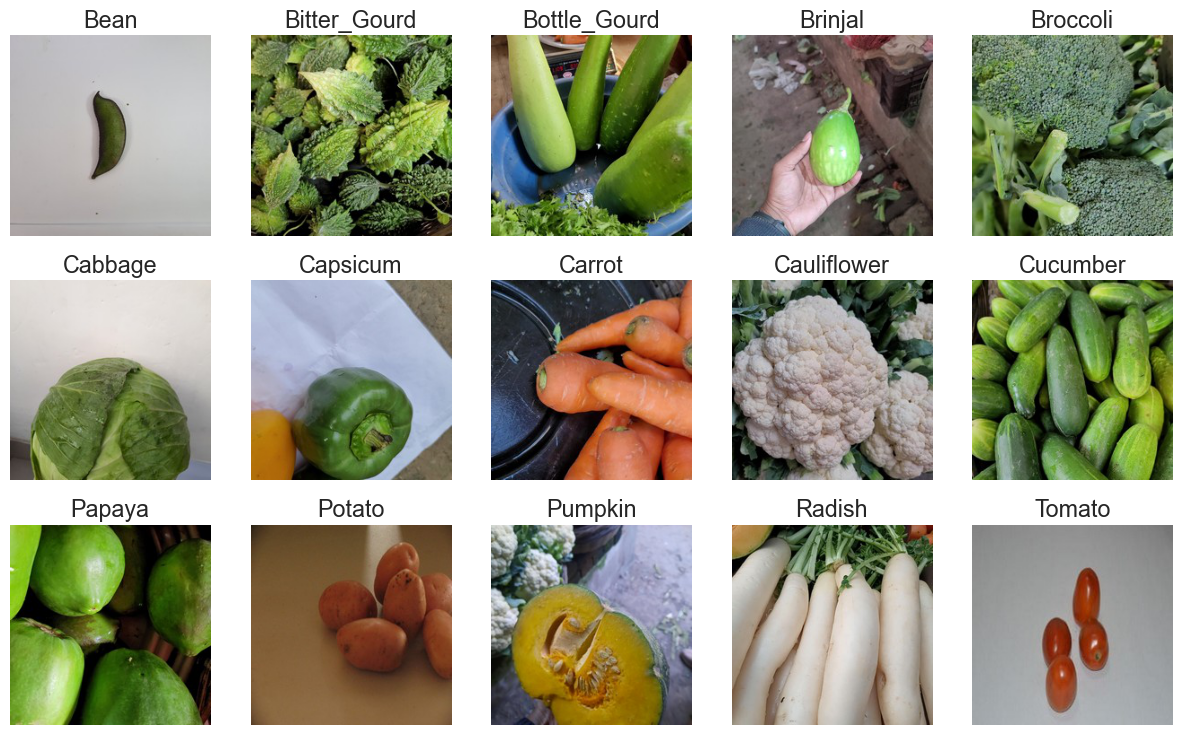

In [268]:
# View first image of each category in the training set
def plot_images(image_categories):
    
    # Create a figure
    plt.figure(figsize=(15,9))
    for i, cat in enumerate(image_categories):
        
        # Load image from each category
        image_path = train_dir + '/' + cat
        images_in_folder = os.listdir(image_path)
        first_image_of_folder = images_in_folder[0]
        first_image_path = image_path + '/' + first_image_of_folder
        img = load_img(first_image_path)
        img_arr = img_to_array(img)/255.0
        
        
        # Create a subplot and plot the images
        plt.subplot(3, 5, i+1)
        plt.imshow(img_arr)
        plt.title(cat)
        plt.axis('off')
        
    plt.show()

# Function call
plot_images(class_names)

## Data Preparation
- Generate a subset of data using take() method from tensorflow datasets to allow for quicker testing. 
- We chose 2048 and 1024 for training and validation subsets, respectively. Somewhat arbitrary but we like using powers of 2 and the size doesn't seem too small or large. 
- We used a little neural network for the sole purpose of rescaling.

In [269]:
# Create subsets of train_ds and val_ds for faster training
train_ds_sample = train_ds.take(2048)
val_ds_sample = val_ds.take(1024)

print(train_ds_sample)
print(val_ds_sample)

<TakeDataset element_spec=(TensorSpec(shape=(150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(15,), dtype=tf.float32, name=None))>
<TakeDataset element_spec=(TensorSpec(shape=(150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(15,), dtype=tf.float32, name=None))>


In [270]:
# Create a small neural network for rescaling values
rescale = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255)
])

#### Setup TensorFlow Pipelines
TensorFlow pipelines used for speed optimizations

- Use AUTOTUNE to dynamically tune pipeline performance at runtime
- map() method to rescale data, normalizing pixel values
- batch() to create batches of desired size
- prefetch() prepares next batch and optimize pipeline performance based on AUTOTUNE

In [271]:
# Tune values dynamically at runtime
autotune = tf.data.AUTOTUNE
# Set up tensorflow pipeline for training dataset
train_ds = train_ds.map(lambda x, y: (rescale(x), y))
train_ds = train_ds.batch(batch_size)
train_ds = train_ds.prefetch(buffer_size=autotune)
# Set up tensorflow pipeline for validation dataset
val_ds = val_ds.map(lambda x, y: (rescale(x), y))
val_ds = val_ds.batch(batch_size)
val_ds = val_ds.prefetch(buffer_size=autotune)

In [272]:
# Pipeline for training subsets
train_ds_sample = train_ds_sample.map(lambda x, y: (rescale(x), y))
train_ds_sample = train_ds_sample.batch(batch_size)
train_ds_sample = train_ds_sample.prefetch(buffer_size=autotune)

val_ds_sample = val_ds_sample.map(lambda x, y: (rescale(x), y))
val_ds_sample = val_ds_sample.batch(batch_size)
val_ds_sample = val_ds_sample.prefetch(buffer_size=autotune)

## Custom Model Training

#### Plotting Loss/Accuracy
- Loss/accuracy plots can help us visualize overfitting/underfitting as well as model training progress

In [273]:
# Helper to plot loss
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.legend()
  plt.grid(True)
  plt.show()

# Helper to plot accuracy
def plot_acc(history):
  plt.plot(history.history['accuracy'], label='accuracy')
  plt.plot(history.history['val_accuracy'], label='val_accuracy')
  plt.legend()
  plt.grid(True)
  plt.show()

#### Create a Model for Hyperparameter Tuning
We will create a convolutional neural network model for image classification tasks. Specifically, it will be sequential model with the following layer types:
- Conv2D 
- MaxPooling
- Dropout (if we think the model is overfitting)
- Flatten 
- Dense
<br>
- Since there aren't any defined guidelines for building the best model we can use hyperparameter tuning to determine optimal:
    - number of layers
    - number of kernels for each Conv2D layer
    - kernel size for all Conv2D layers
    - padding choice for all Conv2D layers
    - learning rate for Adam optimizer
<br>
- We will use the Hyperband tuner to focus more resources on the most promising parameters
- The best parameters will be chosen through multiple trials on our training and validation subsets
- It isn't an exhaustive set of parameters since we don't want to do too many trials to test all the different combinations. (5 layers max, same padding every layer, same kernel size every layer)
- For the classification portion we chose a Dense layer with 32 neurons before our final prediction layer of 15 neurons and softmax activation to suit our classification problem. We decided to leave the dense stuff out of our hyperparameter tuning. We will change it if absolutely necessary.

In [274]:
# Create hypermodel for tuning
def build_model(hp):
    model = Sequential()
    for i in range(hp.Int("num_layers", 1, 5)): # 1-5 Conv2D layers
        # Different kernel numbers each layer
        # Same kernel size every layer,
        # Same padding every layer
        model.add(Conv2D(hp.Choice("kernel_L"+str(i), values=[32, 64, 128, 256, 512]), kernel_size=hp.Choice("kernel_size", values=[3, 5]), input_shape=(150, 150, 3), activation="relu", padding=hp.Choice('padding', values=["same", "valid"])))
        model.add(MaxPooling2D())
        model.add(Dropout(0.2))
    
    # Dense layers for classification
    model.add(Flatten())
    model.add(Dense(32, activation="relu"))
    model.add(Dense(15, activation="softmax")) # Softmax for multiclass classification

    # Learning rate hyperparameter choices
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate), # Adam Optimizer taking in hyperparameter choices
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

#### Tuning Results and Final Model Creation

After determining the best hyperparameters using the hyperband tuner, a model was built using the best hyperparameters and trained using the training and validation sets <br>
We monitored the loss plot during training to determine the model was underfitted or overfitted so we could go back and adjust our hyperparameters (ex. more layers, dropout layers)
We found that our model performed quite well using our initial parameters for the dense layers. 

In the end, our iterative hyperparameter adjustments and model tuning produced the following parameters: 
- Layers: 4
- Conv2D Layer 1 # kernels: 256
- Conv2D Layer 2 # kernels: 512
- Conv2D Layer 3 # kernels: 128
- Conv2D Layer 4 # kernels: 128
- Padding choice: same
- Learning rate: 0.0001
- Kernel size: 3

The final model architecture is recreated in the function defined below called 'final_model()'. Early stopping is used to get the best weights from training and then saved as an h5 file. It can then be loaded into the compiled model and is ready for test data. 

In [275]:
# Final model using architecture and parameters from tuning process
# From hyperparameter tuning:
    # Number of Conv2D Layers: 4
    # Layer 1 # kernels: 256
    # Layer 2 # kernels: 512
    # Layer 3 # kernels: 128
    # Layer 4 # kernels: 128
    # Padding choice: same
    # Learning rate: 0.0001
    # Kernel size: 3

def final_model():

    model = Sequential()

    # Layer 1
    model.add(Conv2D(256, kernel_size=3, input_shape=(150, 150, 3), activation="relu", padding="same"))
    model.add(MaxPooling2D())
    model.add(Dropout(0.2))
    # Layer 2
    model.add(Conv2D(512, kernel_size=3, input_shape=(150, 150, 3), activation="relu", padding="same"))
    model.add(MaxPooling2D())
    model.add(Dropout(0.2))
    # Layer 3
    model.add(Conv2D(128, kernel_size=3, input_shape=(150, 150, 3), activation="relu", padding="same"))
    model.add(MaxPooling2D())
    model.add(Dropout(0.2))
    # Layer 4
    model.add(Conv2D(128, kernel_size=3, input_shape=(150, 150, 3), activation="relu", padding="same"))
    model.add(MaxPooling2D())
    model.add(Dropout(0.2))
    # Classification Layers
    model.add(Flatten())
    model.add(Dense(32, activation="relu"))
    model.add(Dense(15, activation="softmax"))
    # Compile Model
    model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
    )

    return model

#### Switch for Entering Training Mode or Loading Saved Weights
- if training_mode = True, hyperparameter tuning will begin using our training and validation subsets. Then a model will be built using the best hyperparameters and trained using all the training and validation data. The weights will be saved as an h5 file called 'custom_best_weights'
- if training_mode = False, weights will be loaded from a url into a model with the architecture above (final_model())

In [276]:
# Switch for reproducing training results
training_mode = False

In [277]:
if training_mode:
    # Initialize Hyperband tuner
    tuner = kt.Hyperband(hypermodel = build_model,
                     objective=MONITOR,
                     max_epochs=10,
                     factor=3,
                     directory=DIR_OUT,
                     project_name=PROJECT, 
                     overwrite=True)
    # Initialize early stopping, restore model to weights from best epoch, stop if validation accuracy doesn't improve after 3 epochs
    stopping = tf.keras.callbacks.EarlyStopping(monitor=MONITOR, patience=BASE_PATIENCE, mode="max", restore_best_weights=True)
    
    # Get results from different hyperparaters using a subset of training and validation data for speed
    tuner.search(train_ds_sample, epochs=3, validation_data=val_ds_sample, callbacks=[stopping])
    # Get the optimal hyperparameters
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    # Get the optimal hyperparameters
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    # Get the best model
    best_model = tuner.get_best_models(num_models=1)[0]

    # Print best hyperparameters
    numLayers = best_hps.get('num_layers')
    print('Layers:', numLayers)
    for i in range(numLayers):
        print(f'Layer {i+1} # kernels: {best_hps.get("kernel_L"+str(i))}')
    print('Padding choice:', best_hps.get("padding"))
    print('Learning rate:', best_hps.get("learning_rate"))
    print('Kernel size:', best_hps.get('kernel_size'))

    # Build best model
    best_model.build(input_shape=(None, 150, 150, 3))
    best_model.summary()

    # Train on all of training and validation data
    train_log = best_model.fit(train_ds, epochs=BASE_EPOCHS, verbose=1, callbacks=[stopping], validation_data=val_ds)
    # Plot loss to monitor overfitting/underfitting
    plot_loss(train_log)
    # Print best epoch and its validation accuracy
    val_acc_per_epoch = train_log.history['val_accuracy']
    best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
    print(f'Best epoch: {best_epoch:d}')
    print(f'Accuracy: {max(val_acc_per_epoch)}')

    # Save weights
    best_model.save_weights('custom_best_weights', overwrite=False, save_format='h5')

else:
    weights_file = 'custom_best_weights'
    weights_url = 'https://github.com/DarrenPLee/ItML_Project_2_Students/blob/main/custom_best_weights' # Insert your url here

    if not os.path.exists(weights_file):
        wget.download(weights_url, weights_file, bar=bar_custom)

    # Create final model
    final = final_model()
    # Load saved weights
    final.load_weights(weights_file) 


## Transfer Learning Model

- We have chosen to use the VGG16 model since we are familiar with it.
- We removed the 'top' and added our own classification layers. We used the same classification layers as our custom model above because we were satisfied with its accuracy
- After training our initial training of our transfer learning model, we explored fine-tuning to see if we could further improve our training accuracy. We set the learning rate low at 1e-5 to avoid undoing too much of the VGG16s training on substantially more data.

In [278]:
transfer_stopping = tf.keras.callbacks.EarlyStopping(monitor=MONITOR, patience=BASE_PATIENCE, mode="max", restore_best_weights=True)

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_9 (Flatten)         (None, 8192)              0         
                                                                 
 dense_18 (Dense)            (None, 32)                262176    
                                                                 
 dense_19 (Dense)            (None, 15)                495       
                                                                 
Total params: 14,977,359
Trainable params: 262,671
Non-trainable params: 14,714,688
_________________________________________________________________
Epoch 1/100
938/938 [==============================] - 29s 29ms/step - loss: 0.3905 - accuracy: 0.8941 - val_loss: 0.0973 - val_accuracy: 0.9737
Epoch 2/100
938/938 [=

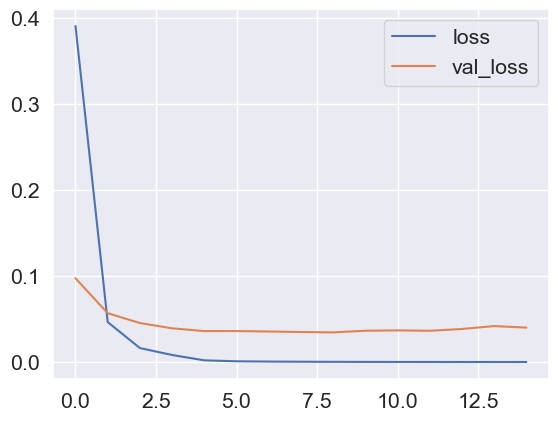

In [279]:
# Load VGG model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
base_model.trainable = False ## Not trainable weights

# Add Dense Layers
flatten_layer = Flatten()
dense_layer_1 = Dense(32, activation='relu', )
prediction_layer = Dense(15, activation='softmax')

transfer_model = Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    prediction_layer
])

transfer_model.summary()

transfer_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

transfer_history = transfer_model.fit(train_ds, epochs=100, validation_data=val_ds, callbacks=[stopping])
plot_loss(transfer_history)


In [280]:
# Unlock VGG16 layers for fine tuning
base_model.trainable = True
transfer_model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_9 (Flatten)         (None, 8192)              0         
                                                                 
 dense_18 (Dense)            (None, 32)                262176    
                                                                 
 dense_19 (Dense)            (None, 15)                495       
                                                                 
Total params: 14,977,359
Trainable params: 14,977,359
Non-trainable params: 0
_________________________________________________________________


In [281]:
# Stop training if there are no improvements after 3 epochs
transfer2_stopping = tf.keras.callbacks.EarlyStopping(monitor=MONITOR, patience=BASE_PATIENCE, mode="max", restore_best_weights=True)

Epoch 1/5
938/938 [==============================] - 76s 80ms/step - loss: 0.0246 - accuracy: 0.9925 - val_loss: 0.0392 - val_accuracy: 0.9893
Epoch 2/5
938/938 [==============================] - 71s 75ms/step - loss: 0.0138 - accuracy: 0.9952 - val_loss: 0.0834 - val_accuracy: 0.9757
Epoch 3/5
938/938 [==============================] - 70s 75ms/step - loss: 0.0076 - accuracy: 0.9981 - val_loss: 0.0222 - val_accuracy: 0.9943
Epoch 4/5
938/938 [==============================] - 74s 79ms/step - loss: 0.0080 - accuracy: 0.9975 - val_loss: 0.0203 - val_accuracy: 0.9950
Epoch 5/5
938/938 [==============================] - 77s 81ms/step - loss: 9.4769e-05 - accuracy: 1.0000 - val_loss: 0.0187 - val_accuracy: 0.9953


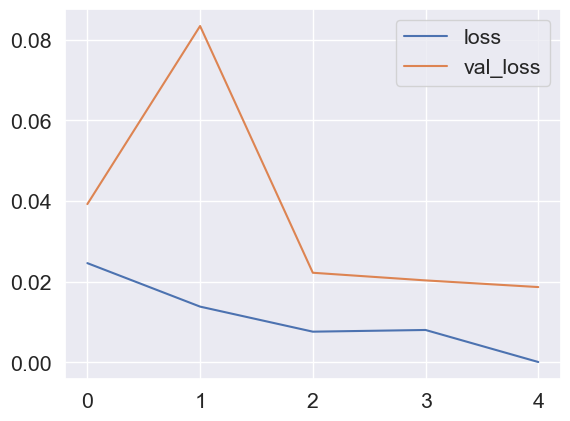

In [282]:
transfer_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),  # Low learning rate
    loss='categorical_crossentropy',
    metrics=["accuracy"]
)

fineTuning_history = transfer_model.fit(train_ds, epochs=5, validation_data=val_ds, verbose=1, callbacks=[transfer2_stopping]) # Limit epochs to 5 based on prior runs
plot_loss(fineTuning_history)

## Test Best Models and Illustrate Results

In [284]:
# Load testing data
test_dir = "Vegetable Images/test"
test_ds = image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='categorical',
    image_size = IMAGE_SIZE,
    batch_size = None,
    shuffle = None
)
# Use similar pipeline for test data as validation data
test_ds = test_ds.map(lambda x, y: (rescale(x), y))
test_ds = test_ds.batch(16)
test_ds = test_ds.prefetch(buffer_size=autotune)

Found 3000 files belonging to 15 classes.


#### Accuracy Scores and Loss 

In [285]:
# Evaluate models' accuracies
custom_model_score = final.evaluate(test_ds, verbose=0)
transfer_model_score = transfer_model.evaluate(test_ds, verbose=0)

print("Custom Model Test Loss:", custom_model_score[0])
print("Custom Model Test Accuracy:", custom_model_score[1])
print()
print("Transfer Model Test Loss:", transfer_model_score[0])
print("Transfer Model Test Accuracy:", transfer_model_score[1])

Custom Model Test Loss: 0.12311157584190369
Custom Model Test Accuracy: 0.9673333168029785

Transfer Model Test Loss: 0.015861935913562775
Transfer Model Test Accuracy: 0.9963333606719971


#### View Some Images and Predictions From Each Class
- Get a random image from each folder in the test data and view the predictions of our custom model and transfer model

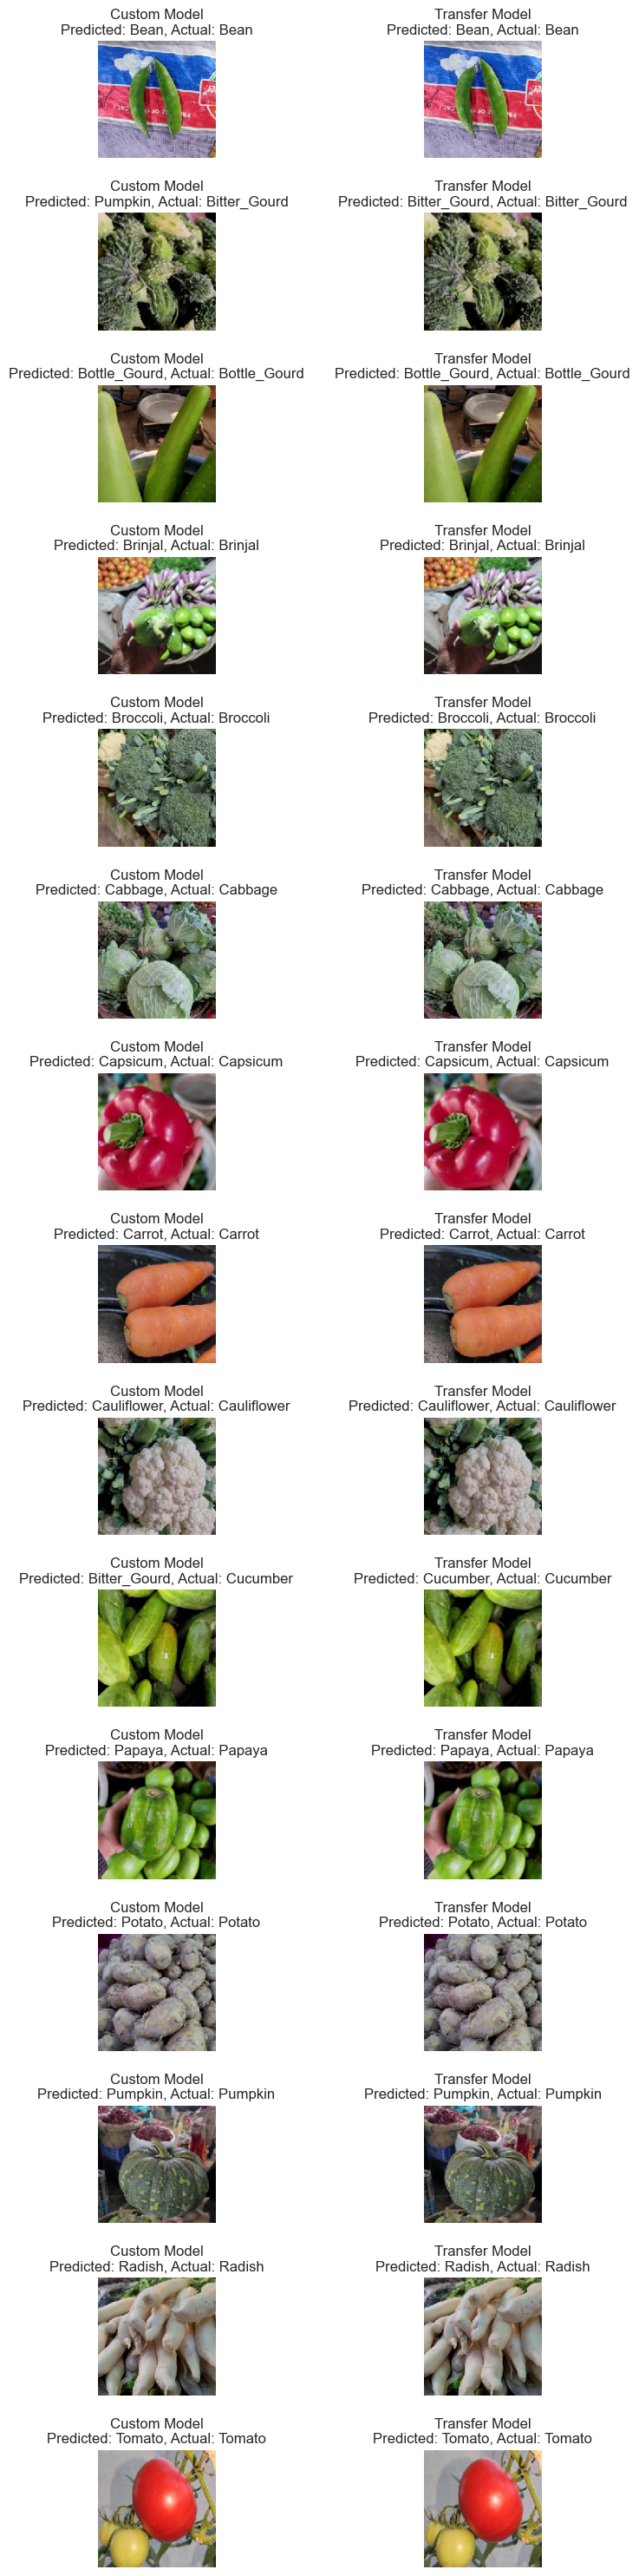

In [286]:
import random
# Create a figure
fig, ax = plt.subplots(15, 2, figsize=(10, 30))
row = 0
for i, cat in enumerate(class_names):
    
    # Load images for the ith category
    image_path = test_dir + '/' + cat
    images_in_folder = os.listdir(image_path)
    random_img_from_folder = random.choice(images_in_folder) 
    random_img_from_folder = os.path.join(image_path, random_img_from_folder)
    
    img = load_img(random_img_from_folder, target_size=(150, 150))
    img_arr = img_to_array(img) / 255.0
    
    img_input = img_arr.reshape((1, img_arr.shape[0], img_arr.shape[1], img_arr.shape[2]))

    custom_label = np.argmax(final.predict(img_input, verbose=0))
    custom_vegetable = class_map[custom_label]

    transfer_label = np.argmax(transfer_model.predict(img_input, verbose=0))
    transfer_vegetable = class_map[transfer_label]

    ax[row, 0].imshow(img)
    ax[row, 0].set_title("Custom Model\nPredicted: {}, Actual: {}".format(custom_vegetable, cat), size=12)
    ax[row, 0].grid()
    ax[row, 0].axis('off')

    ax[row, 1].imshow(img)
    ax[row, 1].set_title("Transfer Model\nPredicted: {}, Actual: {}".format(transfer_vegetable, cat), size=12)
    ax[row, 1].grid()
    ax[row, 1].axis('off')

    row += 1

plt.tight_layout()
plt.show()

#### Confusion Matrices

In [287]:
def plot_confusion_matrix(actual, predicted, classNames, title):
    cm = confusion_matrix(actual, predicted)
    fig = plt.figure(figsize = (8, 8))
    ax1 = fig.add_subplot(1,1,1)
    sns.set(font_scale=1.4) #for label size
    sns.heatmap(cm, annot=True, annot_kws={"size": 12}, cmap='flare_r', fmt='d', xticklabels=classNames, yticklabels=classNames)
    ax1.set_ylabel('True Values',fontsize=14)
    ax1.set_xlabel('Predicted Values',fontsize=14)
    ax1.set_title(title)
    plt.show()

In [288]:
custom_y_pred = []  # store predicted labels
custom_y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in test_ds:
   # append true labels
   custom_y_true.append(np.argmax(label_batch, axis=-1))
   # compute predictions
   custom_preds = final.predict(image_batch, verbose=0)
   # append predicted labels
   custom_y_pred.append(np.argmax(custom_preds, axis=-1))

# convert the true and predicted labels into tensors
custom_correct_labels = tf.concat([item for item in custom_y_true], axis = 0)
custom_predicted_labels = tf.concat([item for item in custom_y_pred], axis = 0)

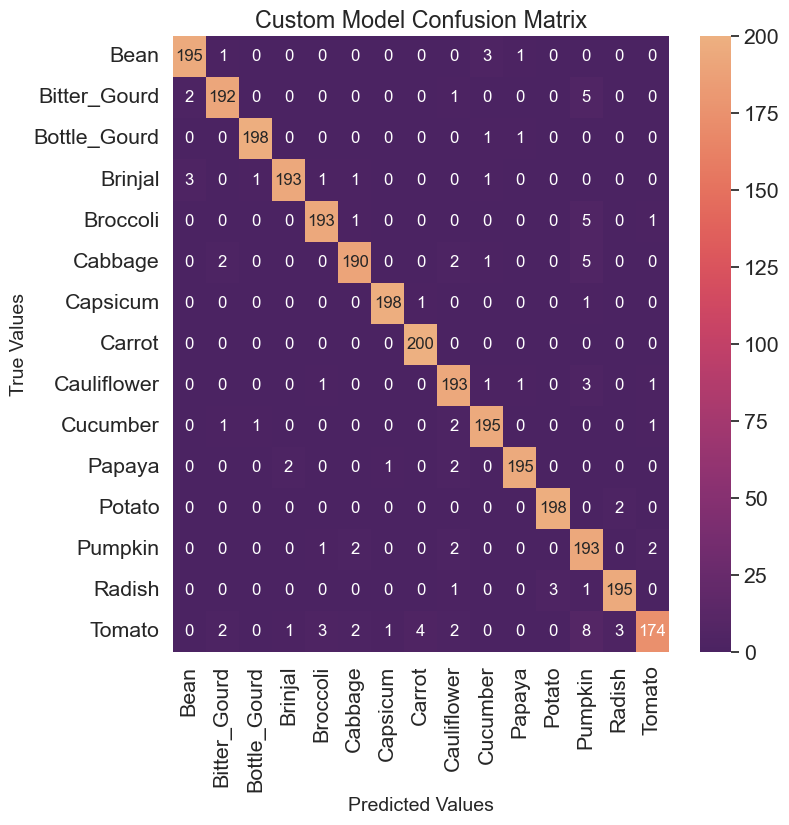

In [289]:
plot_confusion_matrix(custom_correct_labels, custom_predicted_labels, class_names, 'Custom Model Confusion Matrix')

In [290]:
transfer_y_pred = []  # store predicted labels
transfer_y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in test_ds:
   # append true labels
   transfer_y_true.append(np.argmax(label_batch, axis=-1))
   # compute predictions
   transfer_preds = transfer_model.predict(image_batch, verbose=0)
   # append predicted labels
   transfer_y_pred.append(np.argmax(transfer_preds, axis=-1))

# convert the true and predicted labels into tensors
transfer_correct_labels = tf.concat([item for item in transfer_y_true], axis = 0)
transfer_predicted_labels = tf.concat([item for item in transfer_y_pred], axis = 0)

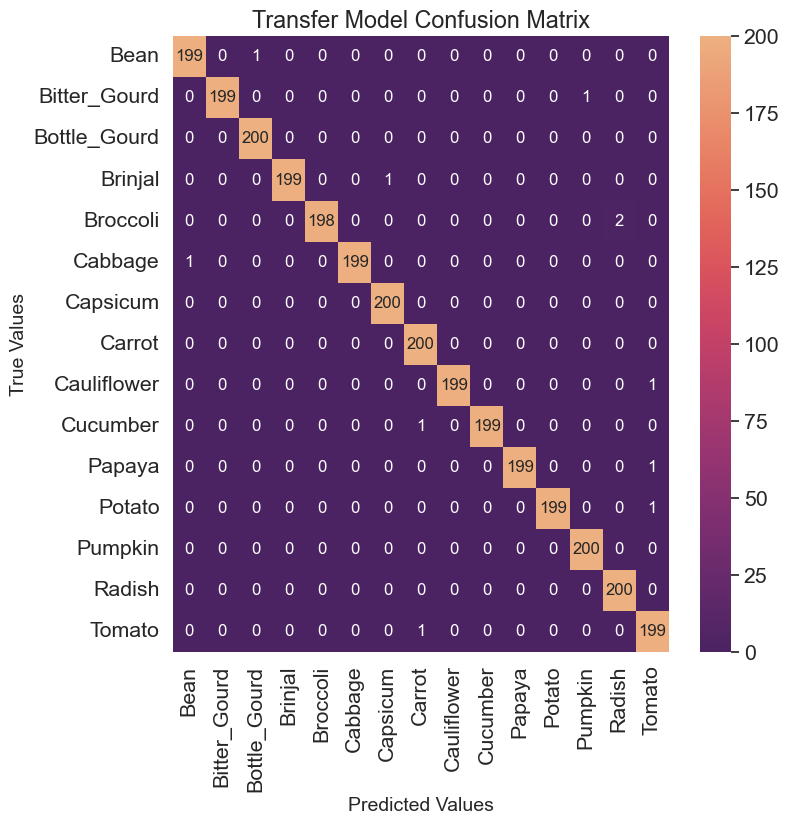

In [291]:
plot_confusion_matrix(transfer_correct_labels, transfer_predicted_labels, class_names, 'Transfer Model Confusion Matrix')

We can see that there are 200 images in each class. The transfer model is significantly more accurate, not misclassifying more than 3 images for each class. The custom model does fairly well, not misclassifying more than 10 images for each class except for tomatoes. Our custom model appears to have the most trouble with differentiating tomatoes with pumpkins. Overall, they both do a pretty good job at classifying vegetables.